In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output

In [2]:
from geoxts.benchmark_data import *
from tsai.all import TSDatasets, TSDataLoaders, TSStandardize, Categorize, get_splits
from tsai.all import FCN, LSTM, InceptionTime, XceptionTime, XCM, LSTM_FCN, LSTM_FCNPlus
from geoxts.benchmark_models import *

In [3]:
#set random seed
random_seed(0, use_cuda=True)

In [4]:
#Testing datastet for the recall calculation
df_log = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_100.parquet', engine='fastparquet')
df_log.loc[df_log['GR'] < -1, 'GR' ] = -1
df_log.loc[df_log['GR'] > 400, 'GR' ] = 400
#df_loc = df_loc.reset_index()
df_loc = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/loc_100.parquet', engine='fastparquet')
df_loc = df_loc.reset_index()
df_log = df_loc.merge(df_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
df_tops = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_100.csv')
df_tops = df_tops.set_index('wellName')
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_tops = df_tops[cols]

In [15]:
#divide into training and testing using df_tops
total_well_list = list(df_tops.index)
train_well_list = total_well_list[:70]
test_well_list = total_well_list[70:]
df_test_tops = df_tops.loc[test_well_list] 

In [16]:

input_variable = ['GR', 'Depth','Latitude','Longitude']
well_array  = []
#extract training data
X, y = extract_dataset_Xy(df_log,df_tops,well_array, input_variable, wsize=201,top_list_bool=0 )
X.shape, y.shape

((1600, 4, 201), (1600,))

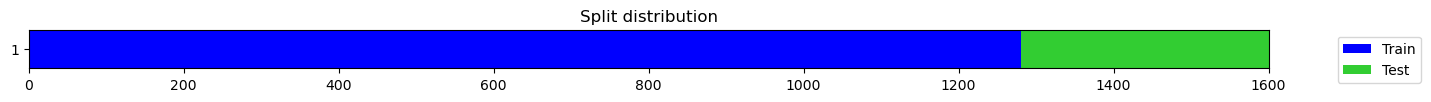

In [17]:
splits = get_splits(y, valid_size=0.2, stratify=True, random_state=23, shuffle=False)
#converting to tesor using inbuit TSDatasets function
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
#tensor dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=25, batch_tfms=[TSStandardize(by_var=True)], num_workers=0) 

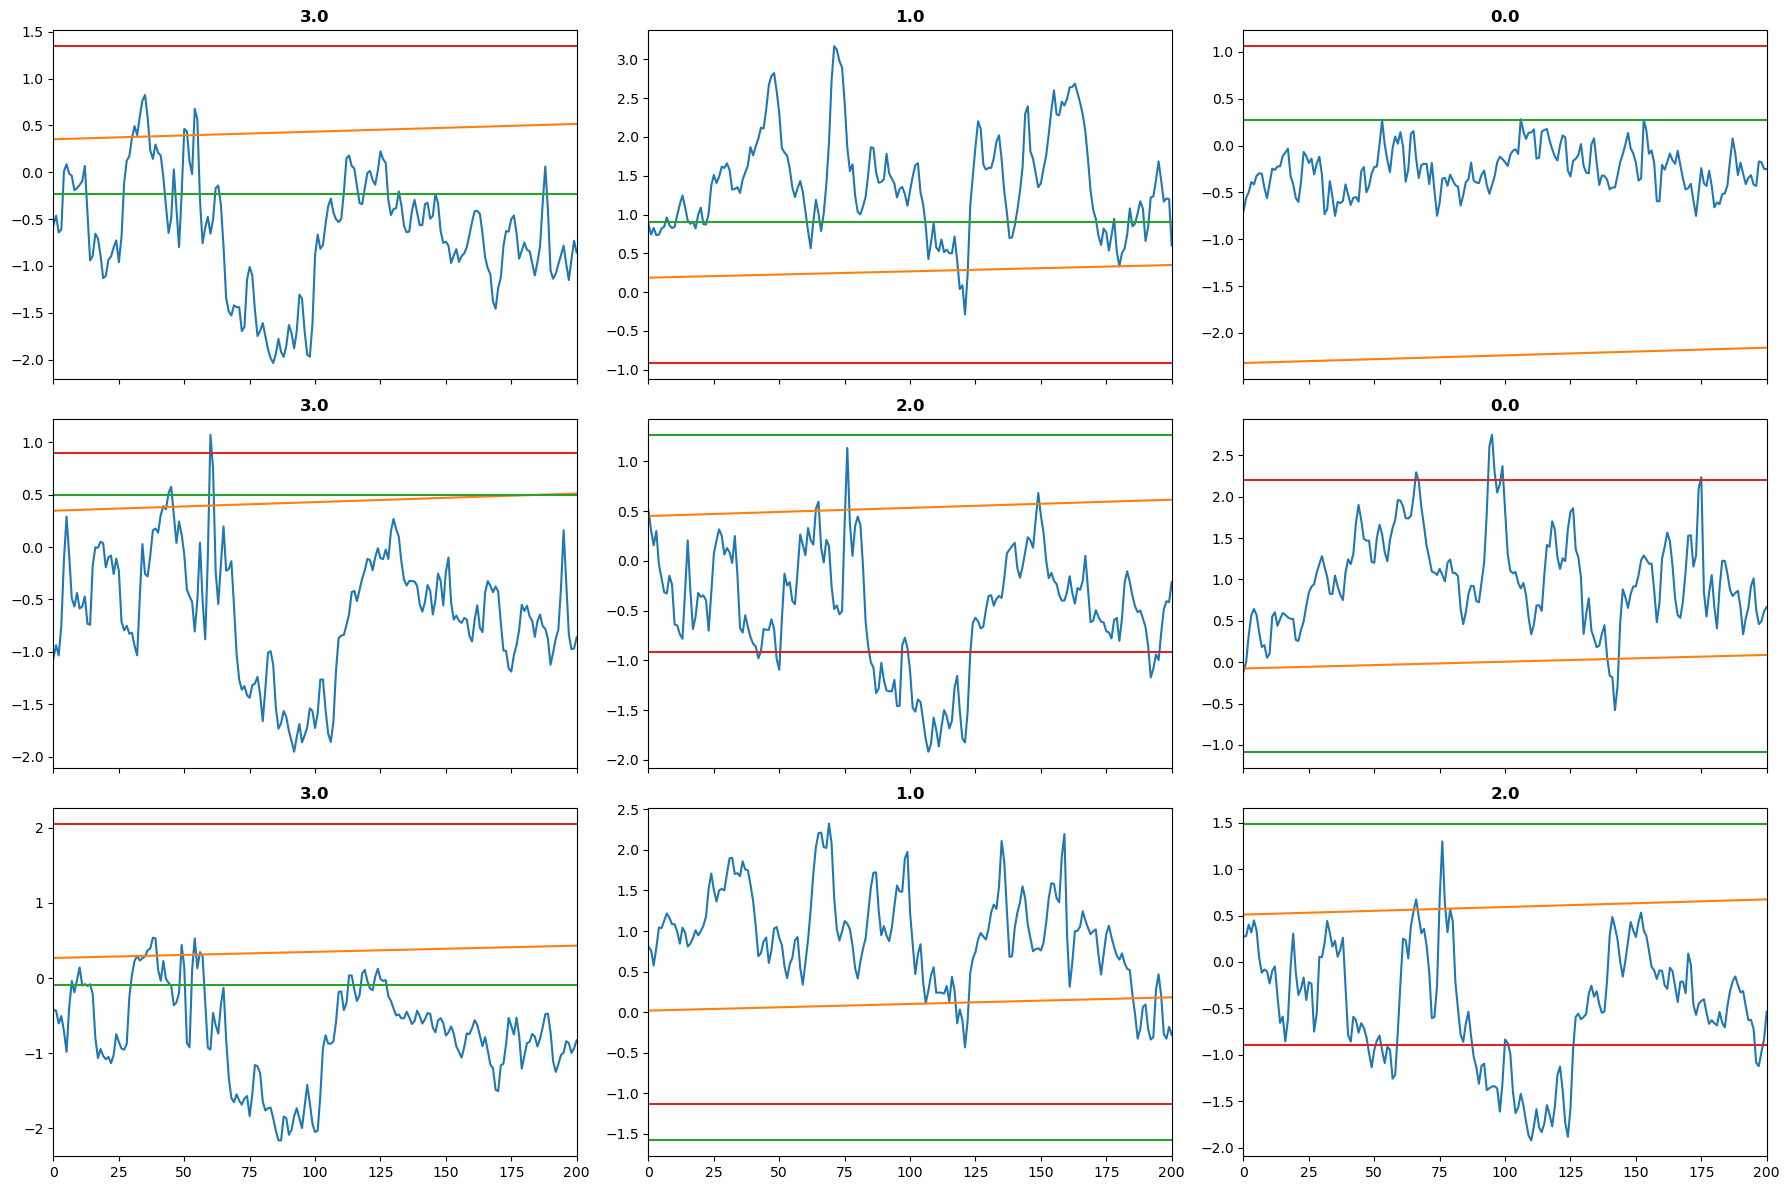

In [18]:
valid_dl = dls.valid
dls.show_batch()

In [19]:
from fastai.learner import *
from fastai.metrics import accuracy
import time

In [20]:
archs = [(LSTM_FCN, {}), (LSTM_FCNPlus, {}), (XCM, {}), (FCN, {}), (InceptionTime, {}), (XceptionTime, {}), 
         (LSTM, {'n_layers':3, 'bidirectional': False}),(LSTM, {'n_layers':3, 'bidirectional': True})]

In [24]:

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(15, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM_FCN,{},388868,0.005185,0.006769,1.00000,27
1,LSTM_FCNPlus,{},388868,0.004870,0.005615,1.00000,27
2,XCM,{},259206,0.009651,0.024818,0.98750,38
3,InceptionTime,{},455940,0.028839,0.054767,0.98750,109
4,XceptionTime,{},399960,0.369522,0.340999,0.97500,106
5,FCN,{},267268,0.354536,0.334472,0.85000,24
6,LSTM,"{'n_layers': 3, 'bidirectional': True}",568804,0.381837,0.506341,0.76875,298
7,LSTM,"{'n_layers': 3, 'bidirectional': False}",204404,0.460140,0.529060,0.70000,132


,arch,hyperparams,mae,recall,Run time
0,LSTM_FCN,{},3.544444,0.988889,77
1,LSTM_FCNPlus,{},3.027778,0.988889,74
2,XCM,{},16.744444,0.866667,105
3,XceptionTime,{},38.433333,0.633333,298
4,InceptionTime,{},9.411111,0.622222,312
5,FCN,{},39.822222,0.288889,66
6,LSTM,"{'n_layers': 3, 'bidirectional': True}",70.100000,0.144444,907
7,LSTM,"{'n_layers': 3, 'bidirectional': False}",93.744444,0.044444,416


In [25]:
archs_made = [(LSTM_2dCNN, {}), (LSTM_XCM, {}), (XCM_LSTM, {}), (LSTM_FCN_2dCNN, {})]

In [26]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs_made):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(15, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM_2dCNN,{},148654,0.000676,0.003695,1.00000,16
1,XCM_LSTM,{},585342,0.000576,0.000519,1.00000,38
2,LSTM_FCN_2dCNN,{},415918,0.000812,0.001852,1.00000,39
3,LSTM_XCM,{},255290,0.000113,0.009465,0.99375,28


,arch,hyperparams,mae,recall,Run time
0,XCM_LSTM,{},3.633333,1.000000,111
1,LSTM_2dCNN,{},2.516667,0.988889,47
2,LSTM_FCN_2dCNN,{},2.166667,0.988889,105
3,LSTM_XCM,{},5.205556,0.966667,79


In [11]:
#optinal download if using any of the functions
from fastai.callback.training import *
from fastai.callback.tracker import *
from fastai.test_utils import *
from fastai.callback.schedule import *

In [21]:
model = build_model(LSTM_FCN, dls=dls)
print(model.__class__.__name__)
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
lr_valley = learn.lr_find(show_plot = False)
learn.fit_one_cycle(20, lr_valley, cbs=[SaveModelCallback(monitor='accuracy'), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])
elapsed = time.time() - start
vals = learn.recorder.values[-1]

LSTM_FCN


epoch,train_loss,valid_loss,accuracy,time
0,1.082356,0.857986,0.706250,00:01
1,0.787503,0.612948,0.740625,00:01
2,0.596264,0.400278,0.962500,00:01
3,0.358737,0.113018,0.987500,00:01
4,0.188845,0.071499,0.987500,00:01
5,0.113270,0.044392,0.987500,00:02
6,0.070990,0.031371,0.987500,00:01
7,0.049048,0.033129,0.987500,00:01
8,0.031444,0.019879,0.987500,00:02
9,0.022110,0.008059,1.000000,00:02


Better model found at epoch 0 with accuracy value: 0.706250011920929.
Better model found at epoch 1 with accuracy value: 0.7406250238418579.
Better model found at epoch 2 with accuracy value: 0.9624999761581421.
Better model found at epoch 3 with accuracy value: 0.987500011920929.
Better model found at epoch 9 with accuracy value: 1.0.
No improvement since epoch 9: early stopping


In [22]:
#prediction on testing well
wsize = 201
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
df_tops_pred_100 = Predicted_well_depth(df_log,df_test_tops, dls, learn, pred_column, wsize, valid_dl, input_variable)
clear_output()
recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred_100,tolerance = 10)
print(mae, recall)

3.2 0.9777777777777777


In [23]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    try: 
        lr_valley = learn.lr_find(show_plot = False)
    except Exception:
        lr_valley =1e-3
    learn.fit_one_cycle(20, lr_valley, cbs=[SaveModelCallback(monitor='accuracy'), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM_FCN,{},388868,0.003273,0.001378,1.000000,36
1,LSTM_FCNPlus,{},388868,0.005413,0.006032,1.000000,29
2,InceptionTime,{},455940,0.006807,0.023206,0.987500,158
3,XceptionTime,{},399960,0.420148,0.398196,0.987500,157
4,XCM,{},259206,0.031058,0.102168,0.962500,27
5,LSTM,"{'n_layers': 3, 'bidirectional': True}",568804,0.049524,0.167623,0.962500,366
6,FCN,{},267268,0.322915,0.312777,0.875000,35
7,LSTM,"{'n_layers': 3, 'bidirectional': False}",204404,0.927786,1.110437,0.546875,99


,arch,hyperparams,mae,recall,Run time
0,LSTM_FCN,{},3.366667,1.000000,72
1,LSTM_FCNPlus,{},2.188889,0.988889,72
2,XCM,{},27.772222,0.744444,104
3,InceptionTime,{},18.577778,0.611111,313
4,XceptionTime,{},29.844444,0.511111,303
5,FCN,{},41.983333,0.311111,67
6,LSTM,"{'n_layers': 3, 'bidirectional': True}",63.166667,0.222222,877
7,LSTM,"{'n_layers': 3, 'bidirectional': False}",122.777778,0.000000,414


In [27]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
result_recall = pd.DataFrame(columns=['arch', 'hyperparams','mae', 'recall', 'Run time'])
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
for i, (arch, k) in enumerate(archs_made):
    model = build_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    try: 
        lr_valley = learn.lr_find(show_plot = False)
    except Exception:
        lr_valley =1e-3
    learn.fit_one_cycle(20, lr_valley, cbs=[SaveModelCallback(monitor='accuracy'), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    wsize = 201
    df_tops_pred = Predicted_well_depth(df_test_log=df_log, df_test_tops=df_test_tops, dls= dls, learn=learn, pred_column=pred_column, wsize=wsize, valid_dl=valid_dl, input_variable= input_variable )
    rtime = time.time() - elapsed - start
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance = 10)
    #print(arch, recall)
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    result_recall.loc[i] = [arch.__name__, k, mae, recall , int(rtime)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    result_recall.sort_values(by='recall', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)
    display(result_recall)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTM_XCM,{},255290,0.002865,0.000695,1.0000,18
1,XCM_LSTM,{},585342,0.002332,0.000672,1.0000,36
2,LSTM_FCN_2dCNN,{},415918,0.001319,0.000311,1.0000,33
3,LSTM_2dCNN,{},148654,0.002477,0.051681,0.9875,17


,arch,hyperparams,mae,recall,Run time
0,LSTM_FCN_2dCNN,{},2.755556,0.988889,105
1,XCM_LSTM,{},2.838889,0.977778,109
2,LSTM_2dCNN,{},7.011111,0.966667,47
3,LSTM_XCM,{},21.694444,0.944444,79
